# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 3 - Bayesian Analysis



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner 


<hr style="height:2pt">

### Homework 3 is due March 5th

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline 
from datetime import datetime as dt
from scipy.special import expit


<hr style="height:2pt">

### Contraceptive Usage by Bangladeshi Women

In the second part of this assignment, you are provided with data sets `dataset_2_train.csv` and `dataset_2_test.csv`containing details of contraceptive usage by 1934 Bangladeshi women. There are four attributes for each woman, along with a label indicating if she uses contraceptives. The attributes include
* district: identifying code for the district the woman lives in
* urban: type of region of residence
* living.children: number of living children
* age-mean: age of the woman (in years, centered around mean)

The women are grouped into 60 districts. The task is to build a classification model that can predict if a given woman uses contraceptives.


### Part A: Bayesian Logistic Regression

The first model we will fit to the contraceptives data is a varying-intercept logistic regression model, where the intercept varies by district.

Prior distribution:

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)$.

$\beta_1 \sim N(0,10000)$, $\beta_2\sim N(0,10000)$, $\beta_3 \sim N(0,10000)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}$,

where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

##### **A1**

As a preprocessing step, map the district number 61 to the number 54 so that the districts are in order. Also, re-name district 60 to be district 0 so that the districts are numbered 0 through 59. **We use this numbering throughout the homework, and will grade using these district numbers**

In [3]:
test_df = pd.read_csv('data/dataset_2_test.csv')
train_df = pd.read_csv('data/dataset_2_train.csv')
train_df.loc[train_df['district'] == 60, 'district'] = 0
test_df.loc[test_df['district'] == 60, 'district'] = 0
train_df.loc[train_df['district'] == 61, 'district'] = 54
test_df.loc[test_df['district'] == 61, 'district'] = 54



##### **A2**

First, we'll verify that pymc3 can recover the hidden parameter values. To do so, we'll hard-code known values and simulate data from the model, then using that data we'll check if pymc3 can get back the parameters we hard-coded. If it does, we'll have hope that it can get the hidden parameter values that generated the real data.

Use the following hard-coded values:  
$\mu_0 = 2$

$\sigma^2_0 = 1$

$\beta_{0j} \sim N(\mu_0,\sigma_0^2)$ for all sixty districts

$\beta_1 = 4$

$\beta_2 = -3$

$\beta_3 = -2$

**Verify that these parameters give an overall average of 46 to 48 percent of subjects using contraceptives**

In [4]:
N = np.shape(train_df)[0]
generated_beta_0 = np.random.normal(2, 1, 60) 
beta_1 = 4
beta_2 = -3
beta_3 = -2
logit_Y = generated_beta_0[train_df['district']] + beta_1*train_df['urban'] + beta_2*train_df['living.children'] + beta_3*train_df['age_mean']
p = expit(logit_Y)
Y = np.random.binomial(size=N, n=1, p=p)
print("Average of Subjects Using Contraceptives:", np.mean(Y))

Average of Subjects Using Contraceptives: 0.47466390899689764


##### **A3**

Fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested in pymc3's warnings.

Note: It is wise to take advantage of a model's built-in `summary` method to inspect it after fitting

In [5]:
# your code here
from pymc3 import Model, Normal, HalfNormal, Gamma, Bernoulli
from pymc3 import traceplot
from scipy import optimize
from pymc3 import NUTS, sample, find_MAP


basic_model = Model()


with basic_model:

    # Priors for unknown model parameters, specifically create stochastic random variables
    # with Normal prior distributions for the regression coefficients,
    # and a half-normal distribution for the standard deviation of the observations, σ.
    mu_0 = Normal('mu_0', mu=0, sd=np.sqrt(10000))
    tau_0 = Gamma('tau_0', alpha=0.1,beta=0.1)
    beta_0 = Normal('beta_0', mu=mu_0, tau=tau_0, shape=60)
    beta_1 = Normal('beta_1', mu=0, sd=np.sqrt(10000))
    beta_2 = Normal('beta_2', mu=0, sd=np.sqrt(10000))
    beta_3 = Normal('beta_3', mu=0, sd=np.sqrt(10000))

    logit = beta_0[train_df['district'].values] + beta_1*train_df['urban'] + beta_2*train_df['living.children']  + beta_3*train_df['age_mean'] 

    # Expected value of outcome - posterior

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', logit_p=logit, observed=Y)
    trace = sample(5000, tune=5000, target_accept=0.99) 

    

    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_3, beta_2, beta_1, beta_0, tau_0, mu_0]
Sampling 4 chains, 0 divergences: 100%|██████████| 40000/40000 [04:32<00:00, 146.93draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [6]:
from pymc3 import NUTS, sample, find_MAP, summary
print(summary(trace).to_string())


             mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  ess_bulk  ess_tail  r_hat
mu_0        1.981  0.765   0.559    3.430      0.039    0.028     382.0   382.0     380.0     765.0   1.01
beta_0[0]   2.509  1.260   0.222    4.830      0.053    0.037     566.0   566.0     560.0    1374.0   1.01
beta_0[1]   1.868  1.001   0.040    3.810      0.041    0.029     603.0   603.0     590.0    1879.0   1.00
beta_0[2]   2.055  1.115  -0.078    4.128      0.041    0.029     740.0   740.0     707.0    2198.0   1.00
beta_0[3]   2.152  1.134   0.087    4.364      0.043    0.031     687.0   687.0     661.0    1841.0   1.00
beta_0[4]   1.887  1.081  -0.135    3.938      0.039    0.027     785.0   785.0     750.0    2072.0   1.00
beta_0[5]   2.127  1.115   0.060    4.233      0.041    0.029     742.0   742.0     703.0    2007.0   1.00
beta_0[6]   1.909  0.992   0.095    3.816      0.038    0.027     672.0   672.0     657.0    1951.0   1.00
beta_0[7]   2.207  1.139   0.199    4

##### **A4**

Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \sigma_0, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged?

/Users/Simon/.conda/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Simon/.conda/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Simon/.conda/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Simon/.conda/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1226d37d0>,
      dtype=object)

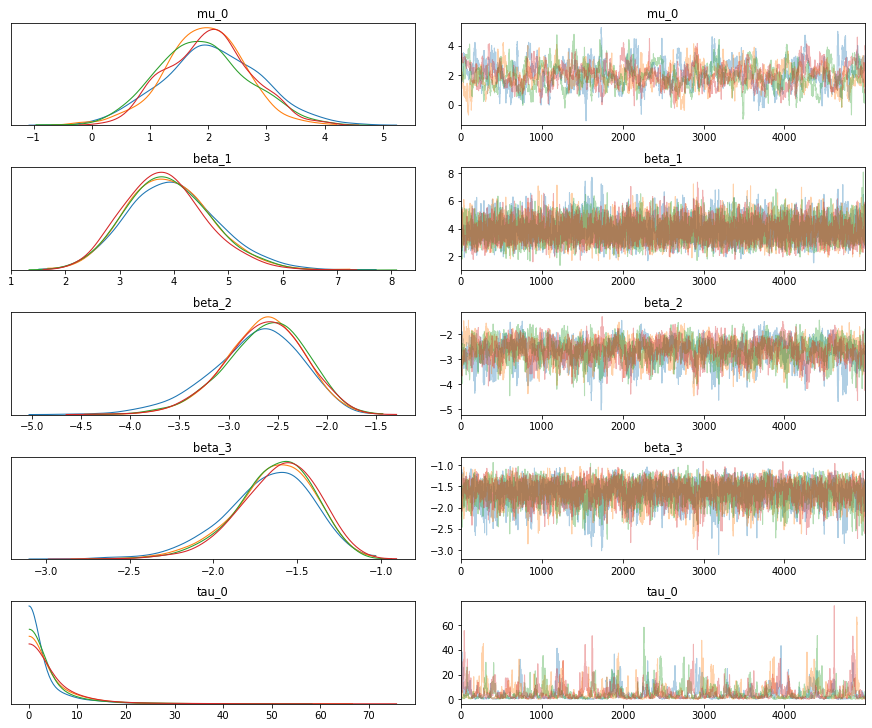

In [7]:
traceplot(trace, ['mu_0', 'beta_1', 'beta_2', 'beta_3', 'tau_0'])

Given an R-hat value of 1 is the strongest sign of convergence, and every single one of my R-hat values is 1.00, 1.01, or 1.02, this is a good sign of convergence. The worst behavior seems to be around the tau value, which coincidentally has the worst R-hat value (still 1.02). Perhaps with more tuning this could be improved.

##### **A5**

Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions? 

Generated Beta 0_9 Value: 2.7272585328718266


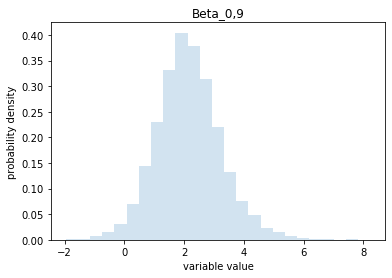

Generated Beta 0_19 Value: 1.711839553871778


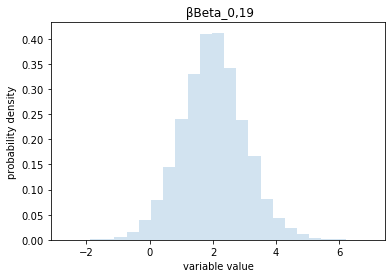

Generated Beta 0_29 Value: 2.4020715439941216


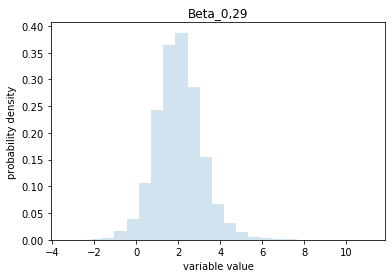

Generated Beta 0_39 Value: 2.966325267405062


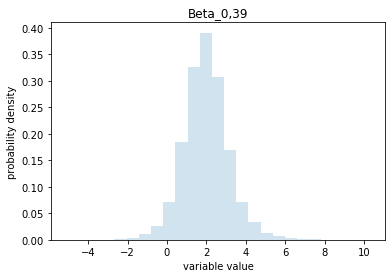

Generated Beta 0_49 Value: 3.293186057659601


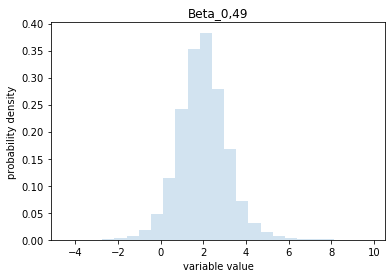

Generated Beta 0_59 Value: 2.0430996294427257


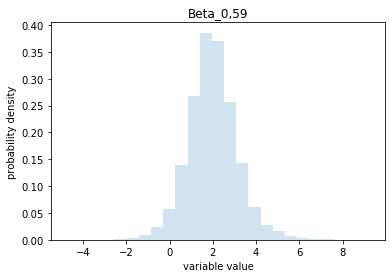

In [8]:
print("Generated Beta 0_9 Value:",generated_beta_0[9])
plt.hist(trace['beta_0'][:,9], density=True, histtype='stepfilled', alpha=0.2, bins=25)
plt.title(r'Beta_0,9')
plt.ylabel(r'probability density')
plt.xlabel(f'variable value')
plt.show()

print("Generated Beta 0_19 Value:",generated_beta_0[19])
plt.hist(trace['beta_0'][:,19], density=True, histtype='stepfilled', alpha=0.2, bins=25)
plt.title(r' βBeta_0,19')
plt.ylabel(r'probability density')
plt.xlabel(f'variable value')
plt.show()

print("Generated Beta 0_29 Value:",generated_beta_0[29])
plt.hist(trace['beta_0'][:,29], density=True, histtype='stepfilled', alpha=0.2, bins=25)
plt.title(r'Beta_0,29')
plt.ylabel(r'probability density')
plt.xlabel(f'variable value')
plt.show()

print("Generated Beta 0_39 Value:",generated_beta_0[39])
plt.hist(trace['beta_0'][:,39], density=True, histtype='stepfilled', alpha=0.2, bins=25)
plt.title(r'Beta_0,39')
plt.ylabel(r'probability density')
plt.xlabel(f'variable value')
plt.show()

print("Generated Beta 0_49 Value:",generated_beta_0[49])
plt.hist(trace['beta_0'][:,49], density=True, histtype='stepfilled', alpha=0.2, bins=25)
plt.title(r'Beta_0,49')
plt.ylabel(r'probability density')
plt.xlabel(f'variable value')
plt.show()

print("Generated Beta 0_59 Value:",generated_beta_0[59])
plt.hist(trace['beta_0'][:,59], density=True, histtype='stepfilled', alpha=0.2, bins=25)
plt.title(r'Beta_0,59')
plt.ylabel(r'probability density')
plt.xlabel(f'variable value')
plt.show()

As demonstrated above, each of the generated values are within the posterior distributions.

##### **A6**

We now fit our model to the actual data. Fit the varying-intercept model to the real training data.

In [9]:
actual_data_model = Model()


with actual_data_model:

    # Priors for unknown model parameters, specifically create stochastic random variables
    # with Normal prior distributions for the regression coefficients,
    # and a half-normal distribution for the standard deviation of the observations, σ.
    mu_0 = Normal('mu_0', mu=0, sd=np.sqrt(10000))
    tau_0 = Gamma('tau_0', alpha=0.1,beta=0.1)
    beta_0 = Normal('beta_0', mu=mu_0, tau=tau_0, shape=60)
    beta_1 = Normal('beta_1', mu=0, sd=np.sqrt(10000))
    beta_2 = Normal('beta_2', mu=0, sd=np.sqrt(10000))
    beta_3 = Normal('beta_3', mu=0, sd=np.sqrt(10000))

    
    logit = beta_0[train_df['district'].values] + beta_1*train_df['urban'] + beta_2*train_df['living.children']  + beta_3*train_df['age_mean'] 

    # Expected value of outcome - posterior

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', logit_p=logit, observed=train_df['contraceptive_use'])
    actual_data_trace = sample(5000, tune=5000, target_accept=0.99) 
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_3, beta_2, beta_1, beta_0, tau_0, mu_0]
Sampling 4 chains, 0 divergences: 100%|██████████| 40000/40000 [02:11<00:00, 303.11draws/s]
The number of effective samples is smaller than 10% for some parameters.


##### **A7**

Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

             mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  ess_bulk  ess_tail  r_hat
mu_0       -1.600  0.255  -2.074   -1.119      0.008    0.005    1151.0  1151.0    1150.0    2361.0    1.0
beta_0[0]  -2.069  0.494  -2.979   -1.128      0.009    0.006    3254.0  3254.0    3218.0    6435.0    1.0
beta_0[1]  -2.124  0.376  -2.818   -1.412      0.009    0.006    1917.0  1917.0    1906.0    4636.0    1.0
beta_0[2]  -1.778  0.489  -2.704   -0.874      0.008    0.006    3550.0  3550.0    3546.0    8003.0    1.0
beta_0[3]  -1.493  0.590  -2.642   -0.397      0.008    0.006    5348.0  4953.0    5318.0    9695.0    1.0
beta_0[4]  -1.433  0.468  -2.281   -0.525      0.008    0.005    3856.0  3819.0    3863.0    8046.0    1.0
beta_0[5]  -1.593  0.471  -2.509   -0.740      0.008    0.005    3864.0  3864.0    3872.0    8293.0    1.0
beta_0[6]  -1.963  0.410  -2.742   -1.205      0.008    0.005    2935.0  2935.0    2919.0    6161.0    1.0
beta_0[7]  -1.996  0.497  -2.935   -1

/Users/Simon/.conda/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Simon/.conda/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Simon/.conda/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Simon/.conda/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f939790>,
      dtype=object)

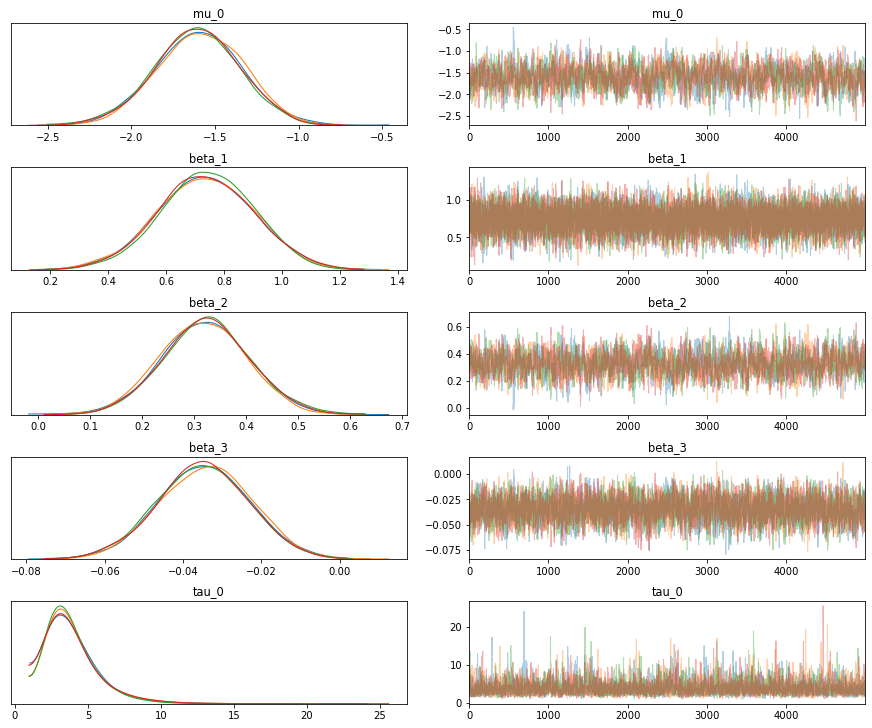

In [10]:
print(summary(actual_data_trace).to_string())
traceplot(actual_data_trace, ['mu_0', 'beta_1', 'beta_2', 'beta_3', 'tau_0'])

As mentioned earlier, an R-Hat value of 1 is the strongest. In this case, every single parameter has a perfect R-hat value of 1. This is similarly demonstrated by the trace plots, in which each of the 4 traces seems to to reflect a similar distribution. 

##### **A8**

Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest?

In [11]:
#your code here
avg_means = np.mean(trace['beta_0'], axis=0)
print("Highest Average Beta District",np.argmax(avg_means))
print("Lowest Average Beta District",np.argmin(avg_means))


Highest Average Beta District 52
Lowest Average Beta District 46


your response here

##### **A9**

What are the posterior means of $\mu_0$ and $\sigma^2_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts or a model with an intercept of 0 for all districts?

Mean Mu_0: -1.5997065652753995


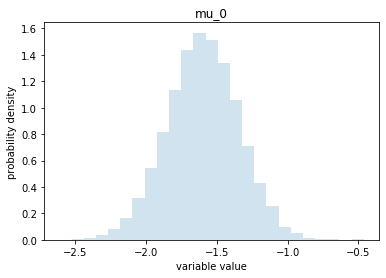

Mean Rho^2_0: 0.301769865889268


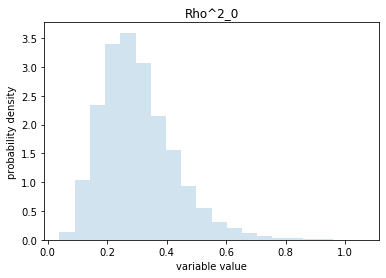

In [12]:
#your code here

print("Mean Mu_0:",np.mean(actual_data_trace['mu_0']))
plt.hist(actual_data_trace['mu_0'], density=True, histtype='stepfilled', alpha=0.2, bins=25)
plt.title(r'mu_0')
plt.ylabel(r'probability density')
plt.xlabel(f'variable value')

plt.show()

print("Mean Rho^2_0:",np.mean(1/actual_data_trace['tau_0']))
plt.hist(1/actual_data_trace['tau_0'], density=True, histtype='stepfilled', alpha=0.2, bins=20)
plt.title(r'Rho^2_0')
plt.ylabel(r'probability density')
plt.xlabel(f'variable value')
plt.show()

Certainly, given that the posterior mean of mu is significantly away from zero, and the variance is small, there is evidence that setting a value of 0 for all districts is NOT ideal. 

The intermediary step of setting a single intercept for all districts yields 
Now I'll create the an additional models, one with a single intercept for all districts, and one with an intercept of 0 for all districts.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_3, beta_2, beta_1, beta_0, tau_0, mu_0]
Sampling 4 chains, 57 divergences: 100%|██████████| 40000/40000 [13:51<00:00, 48.10draws/s] 
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9532413197405643, but should be close to 0.99. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


Single Intercept - Mean Mu_0: -0.04537177962231758


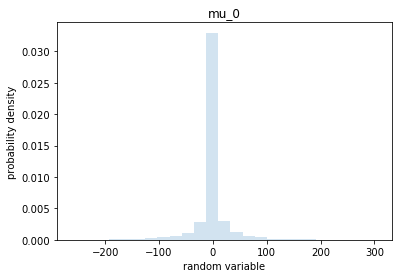

Single Intercept - Mean Rho^2_0: 977192.0708223217


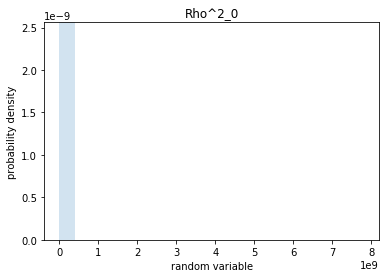

In [13]:
single_intercept_model = Model()


with single_intercept_model:

    # Priors for unknown model parameters, specifically create stochastic random variables
    # with Normal prior distributions for the regression coefficients,
    # and a half-normal distribution for the standard deviation of the observations, σ.
    mu_0 = Normal('mu_0', mu=0, sd=np.sqrt(10000))
    tau_0 = Gamma('tau_0', alpha=0.1,beta=0.1)
    beta_0 = Normal('beta_0', mu=mu_0, tau=tau_0)
    beta_1 = Normal('beta_1', mu=0, sd=np.sqrt(10000))
    beta_2 = Normal('beta_2', mu=0, sd=np.sqrt(10000))
    beta_3 = Normal('beta_3', mu=0, sd=np.sqrt(10000))

    
    logit = beta_0*train_df['district'] + beta_1*train_df['urban'] + beta_2*train_df['living.children']  + beta_3*train_df['age_mean'] 

    # Expected value of outcome - posterior

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', logit_p=logit, observed=train_df['contraceptive_use'])
    single_intercept_trace = sample(5000, tune=5000, target_accept=0.99) 
#your code here

print("Single Intercept - Mean Mu_0:",np.mean(single_intercept_trace['mu_0']))
plt.hist(single_intercept_trace['mu_0'], density=True, histtype='stepfilled', alpha=0.2, bins=25)
plt.title(r'mu_0')
plt.ylabel(r'probability density')
plt.xlabel(f'random variable')
plt.show()


print("Single Intercept - Mean Rho^2_0:",np.mean(1/single_intercept_trace['tau_0']))
plt.hist(1/single_intercept_trace['tau_0'], density=True, histtype='stepfilled', alpha=0.2, bins=20)
plt.title(r'Rho^2_0')
plt.ylabel(r'probability density')
plt.xlabel(f'random variable')
plt.show()

Given it is must harder to converge with a single value for all districts, as well as the HUGE variance in this situation, I'd argue that having a distinct intercept per district is ideal.

### Part B: Varying-Coefficients Model

The next model we will fit to the contraceptives data is a varying-coefficients logistic regression model, where the coefficients on living.children, age-mean, and urban vary by district.

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma_0^2} \sim \text{Gamma}(0.1,0.1)$.

$\beta_{1j} \sim N(0,\sigma_1^2)$, with $\frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1)$

$\beta_{2j}\sim N(0,\sigma_2^2)$, with $\frac{1}{\sigma^2_2}\sim \text{Gamma}(0.1,0.1)$

$\beta_{3j} \sim N(0,\sigma_3^2)$, with $\frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}$,

##### **B1**

Fit the model to the real data. Plot posterior means for each of the coefficients to the predictors. What do you conclude from these graphs?


I will be using the model from the previous problem, which assumes that the coefficients vary by district. 

In [14]:
#your code here
vc_model = Model()


with vc_model:

    # Priors for unknown model parameters, specifically create stochastic random variables
    # with Normal prior distributions for the regression coefficients,
    # and a half-normal distribution for the standard deviation of the observations, σ.
    mu_0 = Normal('mu_0', mu=0, sd=np.sqrt(10000))
    tau_0 = Gamma('tau_0', alpha=0.1,beta=0.1)
    beta_0 = Normal('beta_0', mu=mu_0, tau=tau_0, shape=60)
    tau_1 = Gamma('tau_1', alpha=0.1,beta=0.1)
    beta_1 = Normal('beta_1', mu=0, tau=tau_1, shape=60)
    tau_2 = Gamma('tau_2', alpha=0.1,beta=0.1)
    beta_2 = Normal('beta_2', mu=0, tau=tau_2, shape=60)
    tau_3 = Gamma('tau_3', alpha=0.1,beta=0.1)
    beta_3 = Normal('beta_3', mu=0, tau=tau_3, shape=60)


    logit = beta_0[train_df['district'].values] + beta_1[train_df['district'].values]*train_df['urban'] + beta_2[train_df['district'].values]*train_df['living.children']  + beta_3[train_df['district'].values]*train_df['age_mean'] 
    # Expected value of outcome - posterior

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', logit_p=logit, observed=train_df['contraceptive_use'])
    vc_trace = sample(5000, tune=5000, target_accept=0.99) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_3, tau_3, beta_2, tau_2, beta_1, tau_1, beta_0, tau_0, mu_0]
Sampling 4 chains, 0 divergences: 100%|██████████| 40000/40000 [04:12<00:00, 158.47draws/s]
The number of effective samples is smaller than 10% for some parameters.


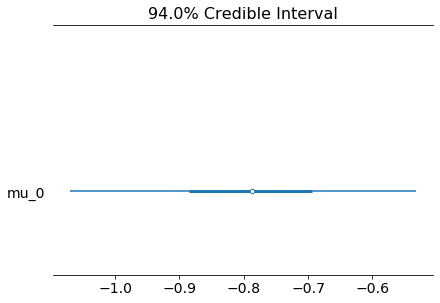

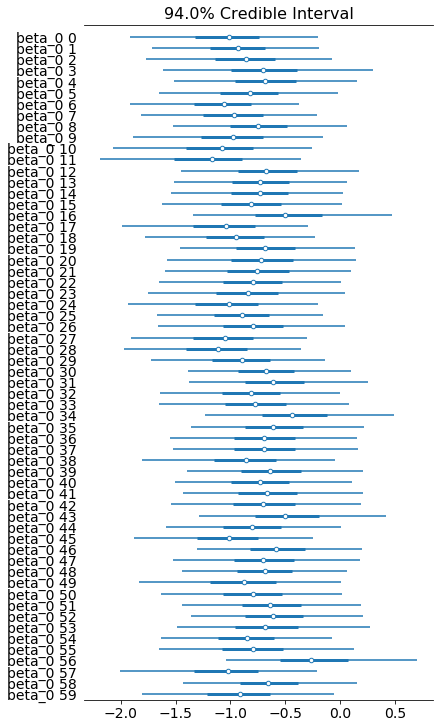

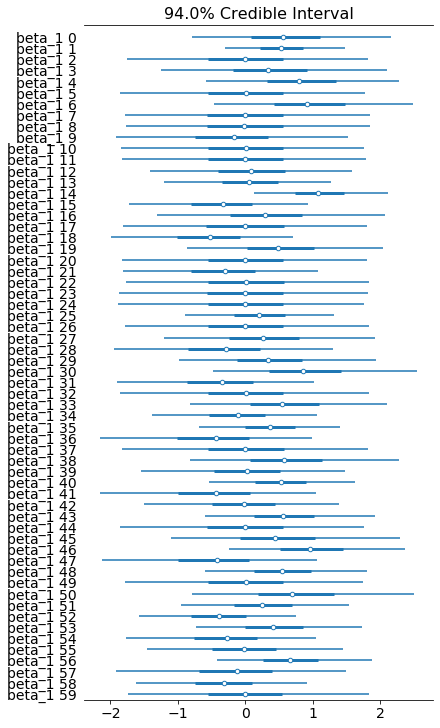

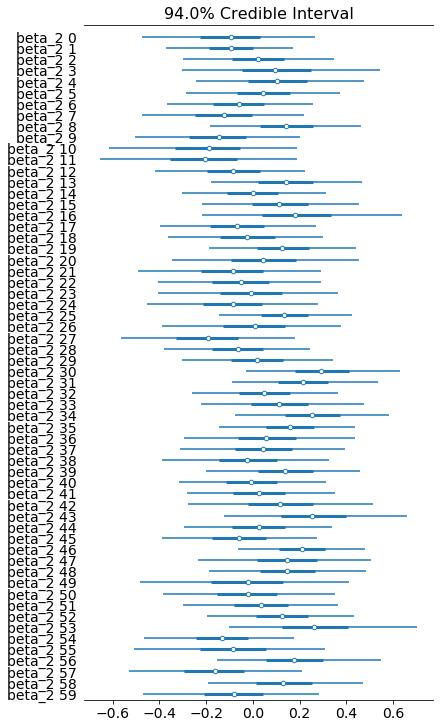

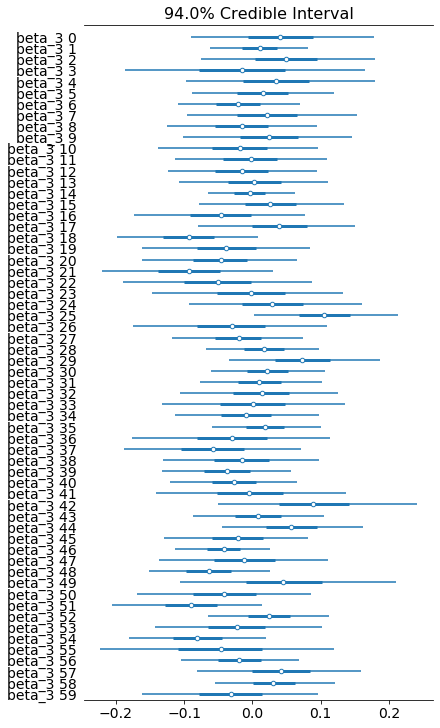

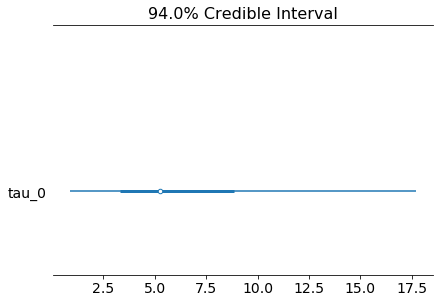

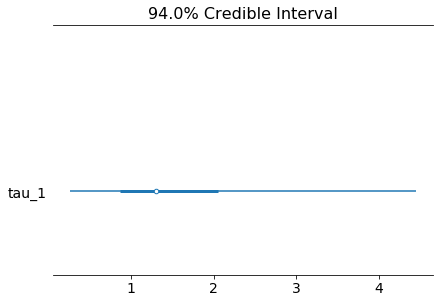

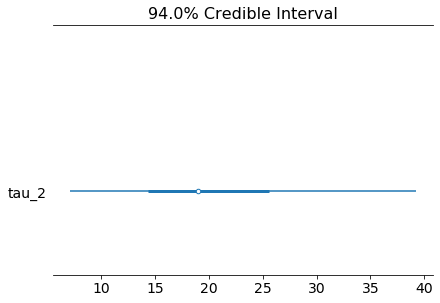

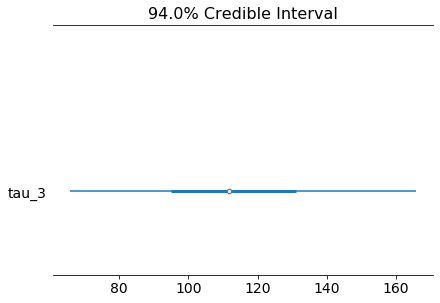

In [15]:
var_names = ['mu_0','beta_0','beta_1','beta_2','beta_3','tau_0','tau_1','tau_2','tau_3']
for x in var_names:
    pm.plot_forest(vc_trace, var_names=[x], combined=True)

Given the large range in mean and variance for the beta values, I'd say this demonstrates that indeed, districts are better captured by distinct beta values as opposed to having one per all districts. This is a logical takeaway from the end of problem 1, where we determined that having a distinct beta_0 per district was preferred. Thus, having a distinct value for each beta per district is ideal.

##### **B2**

Use all of the information you've gleaned thus far to build a final Bayesian logistic regression classifier on the train set. Then, use your model to make predictions on the test set. Report your model's classification percentage.

In [16]:
from sklearn.metrics import accuracy_score
#I'll use the model from above, where beta_0, beta_1, beta_2, beta_3 are per district
beta_0 = np.mean(vc_trace.beta_0, axis=0)
beta_1 = np.mean(vc_trace.beta_1, axis=0)
beta_2 = np.mean(vc_trace.beta_2, axis=0)
beta_3 = np.mean(vc_trace.beta_3, axis=0)
logit = beta_0[test_df['district'].values] + beta_1[test_df['district'].values]*test_df['urban'] + beta_2[test_df['district'].values]*test_df['living.children']  + beta_3[test_df['district'].values]*test_df['age_mean'] 
pred_p = expit(logit)
y_test_pred = [1 if p > 0.5 else 0 for p in pred_p]
print("Accuracy Score on Test Data: ", accuracy_score(test_df.contraceptive_use, y_test_pred))

Accuracy Score on Test Data:  0.6194415718717684


Note the classification accuracy score above. 

Given the takeaway from the last problem, where I found that having a distinct value for each beta per district was preferred, I'm using this model.